 <span style="color:#42a5f5; font-size:2em; font-weight:bold;">Time series sur les données d'incidents</span>

<span style="color:#e91e63; font-size:1em; font-weight:bold;">1. Import des bibliothèques necessaires</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
print(" ~~ Début de la Modélisation des Séries Temporelles ~~ ")

# Chargement
processed_file_path = r"..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv"
if not os.path.exists(processed_file_path):
    raise FileNotFoundError(f"Le fichier {processed_file_path} n'existe pas. Veuillez vérifier le chemin.")

print(f"Chargement du fichier : {processed_file_path}")

# Colonnes utiles pour la time series
cols_to_keep = [
    "IncidentNumber", "DateOfCall", "TimeOfCall", "HourOfCall",
    "NumCalls", "NotionalCost", "PumpCount",
    "NumPumpsAttending", "NumStationsWithPumpsAttending"
]

# Typage strict uniquement sur les colonnes conservées
dtype_map = {
    "IncidentNumber": "string",
    "TimeOfCall": "string",
    "HourOfCall": "Int64",
    "NumCalls": "Int64",
    "NotionalCost": "Int64",
    "PumpCount": "Int64",
    "NumPumpsAttending": "Int64",
    "NumStationsWithPumpsAttending": "Int64",
}

 ~~ Début de la Modélisation des Séries Temporelles ~~ 
Chargement du fichier : ..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv


In [4]:
# Chargement avec conversion explicite
df = pd.read_csv(processed_file_path, usecols=cols_to_keep, dtype=dtype_map, parse_dates=["DateOfCall"], dayfirst=True)
df = df[df["DateOfCall"].notna()] 

print("Type de la colonne DateOfCall :", df['DateOfCall'].dtype)
print("Aperçu des valeurs de DateOfCall :")
display(df['DateOfCall'].head(10))

print("\nAperçu des 5 premières lignes du DataFrame :")
display(df.head())
print("types de données dans le DataFrame :")
print(df.dtypes)

# vérification des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

print("\nStatistiques descriptives :")
display(df.describe(include='all'))

print("Période de la série temporelle :")   
print(f"De {df['DateOfCall'].min()} à {df['DateOfCall'].max()}")

Type de la colonne DateOfCall : object
Aperçu des valeurs de DateOfCall :


0    2009-01-01
1    2009-01-01
2    2009-01-01
3    2009-01-01
4    2009-01-01
5    2009-01-01
6    2009-01-01
7    2009-01-01
8    2009-01-01
9    2009-01-01
Name: DateOfCall, dtype: object


Aperçu des 5 premières lignes du DataFrame :


,IncidentNumber,DateOfCall,TimeOfCall,HourOfCall,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,NotionalCost,NumCalls
0,235138081,2009-01-01,00:00:37,0,2,2,2,255,1
1,1091,2009-01-01,00:00:46,0,<NA>,<NA>,1,255,1
2,2091,2009-01-01,00:03:00,0,1,1,1,255,2
3,3091,2009-01-01,00:04:27,0,1,1,1,255,2
4,5091,2009-01-01,00:05:39,0,1,2,2,255,1


types de données dans le DataFrame :
IncidentNumber                   string[python]
DateOfCall                               object
TimeOfCall                       string[python]
HourOfCall                                Int64
NumStationsWithPumpsAttending             Int64
NumPumpsAttending                         Int64
PumpCount                                 Int64
NotionalCost                              Int64
NumCalls                                  Int64
dtype: object
Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                         0
NumCalls                          1849
dtype: int64

Statistiques descriptives :


,IncidentNumber,DateOfCall,TimeOfCall,HourOfCall,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,NotionalCost,NumCalls
count,1824973,1824973,1824973,1824973.0,1810351.0,1810351.0,1824973.0,1824973.0,1823124.0
unique,1824973,5934,86394,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
top,21091,2021-07-12,18:02:06,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
freq,1,1058,56,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
mean,NaN,NaN,NaN,13.462605,1.370929,1.555361,1.592914,407.816033,1.327807
std,NaN,NaN,NaN,6.258045,0.687726,0.845371,1.582791,2701.663304,1.487098
min,NaN,NaN,NaN,0.0,1.0,1.0,1.0,255.0,1.0
25%,NaN,NaN,NaN,9.0,1.0,1.0,1.0,290.0,1.0
50%,NaN,NaN,NaN,14.0,1.0,1.0,1.0,328.0,1.0
75%,NaN,NaN,NaN,19.0,2.0,2.0,2.0,364.0,1.0


Période de la série temporelle :
De 2009-01-01 à 2025-03-31


In [5]:
#vérification des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                         0
NumCalls                          1849
dtype: int64


Construction de la série quotidienne:

In [6]:
# Conversion forcée si nécessaire
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'], dayfirst=True, errors='coerce')

# Indexation
df.set_index('DateOfCall', inplace=True)

print("\nType d'index :", type(df.index))
print("Aperçu des données après indexation :")
print(df.head())


Type d'index : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Aperçu des données après indexation :
           IncidentNumber TimeOfCall  HourOfCall  \
DateOfCall                                         
2009-01-01      235138081   00:00:37           0   
2009-01-01           1091   00:00:46           0   
2009-01-01           2091   00:03:00           0   
2009-01-01           3091   00:04:27           0   
2009-01-01           5091   00:05:39           0   

            NumStationsWithPumpsAttending  NumPumpsAttending  PumpCount  \
DateOfCall                                                                
2009-01-01                              2                  2          2   
2009-01-01                           <NA>               <NA>          1   
2009-01-01                              1                  1          1   
2009-01-01                              1                  1          1   
2009-01-01                              1                  2          2   

 

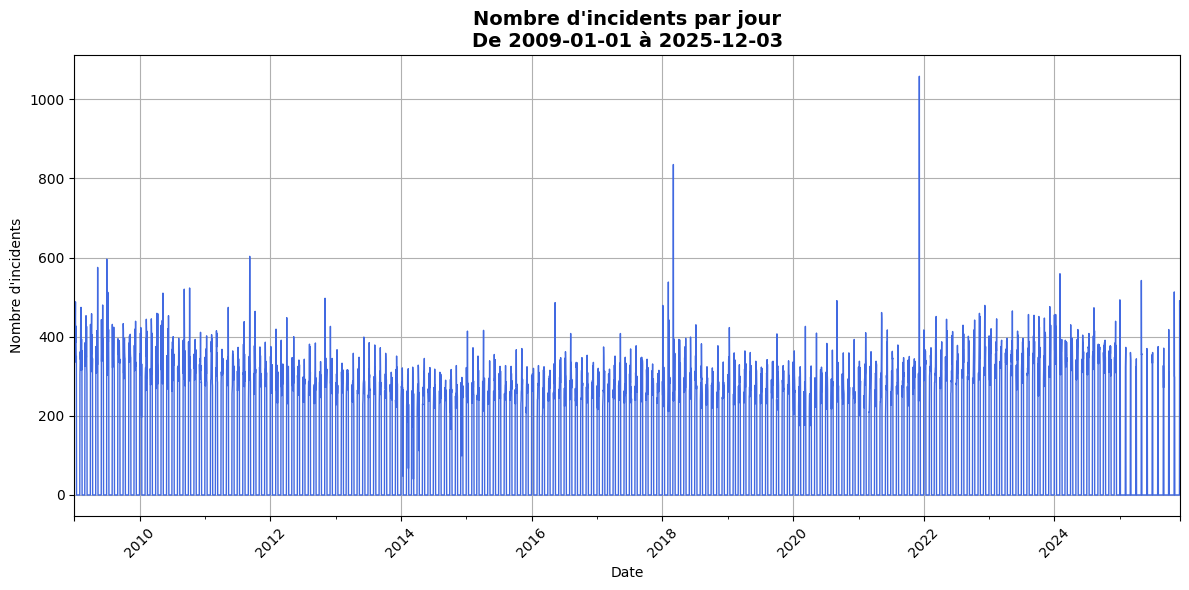

In [15]:
# Série temporelle agrégée : nombre d’incidents par jour
daily_counts = df.resample('D').size()

# Dates min et max
start_date = daily_counts.index.min().date()
end_date = daily_counts.index.max().date()

# VISUALISATION JOURNALIÈRE simplifiée avec titre enrichi
plt.figure(figsize=(12, 6))
daily_counts.plot(color='royalblue', linewidth=1)

plt.title(f"Nombre d'incidents par jour\nDe {start_date} à {end_date}", fontweight="bold", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
# Couleurs dédiées
COLORS = {
    "daily":   "royalblue",
    "weekly":  "#08bdbd",
    "monthly": "seagreen",
    "yearly":  "#ff5c8a",
}

# Périodes saisonnières estimées
PERIODS = {"daily": 365, "weekly": 52, "monthly": 12, "yearly": None}


Visualisation de la série temporelle Daily :


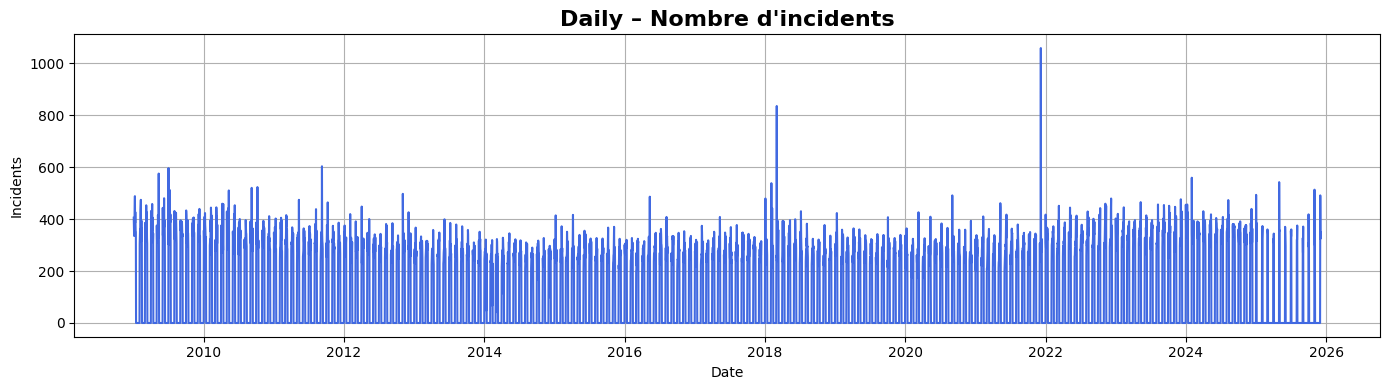


Visualisation de la série temporelle Weekly :


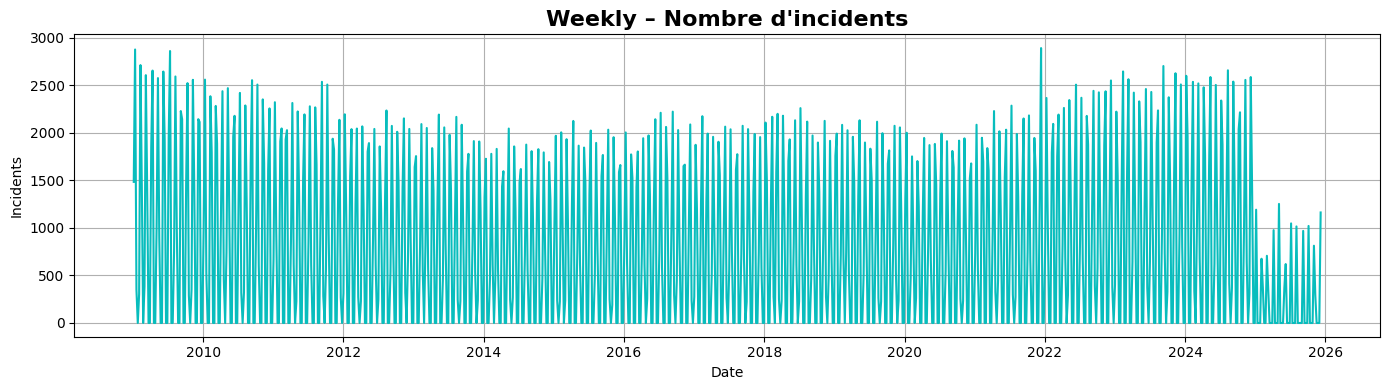


Visualisation de la série temporelle Monthly :


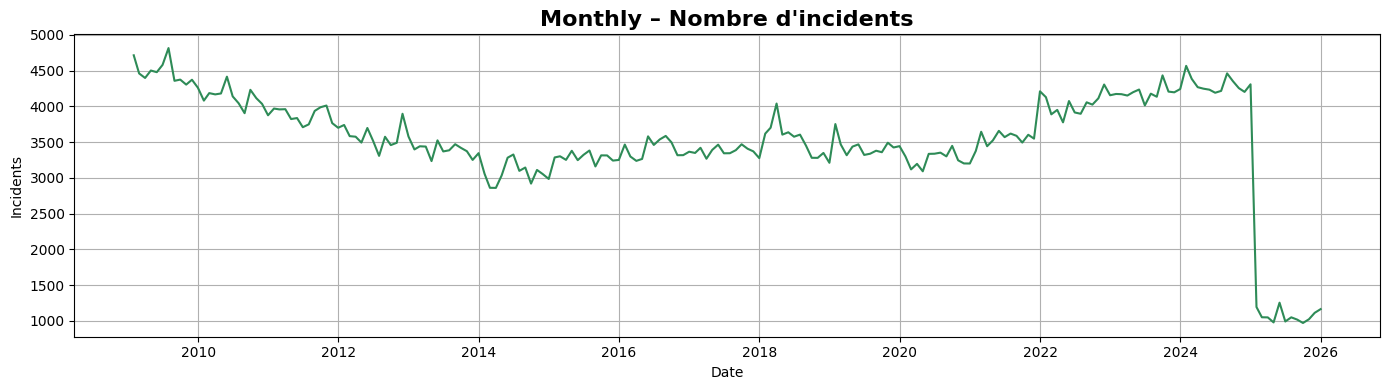


Visualisation de la série temporelle Yearly :


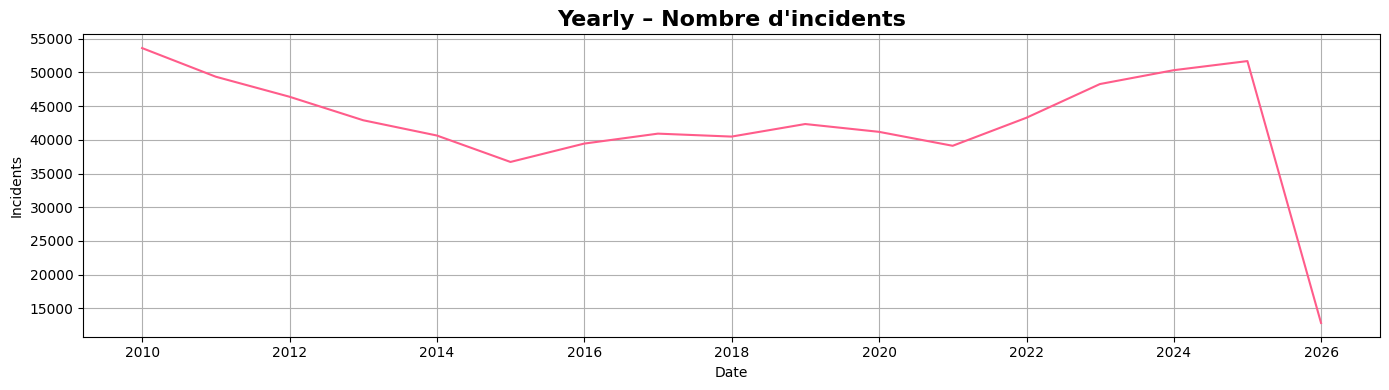

In [17]:
#Agrégations temporelles
ts_dict = {
    "daily":   df.resample("D").size(),
    "weekly":  df.resample("W").size(),
    "monthly": df.resample("M").size(),
    "yearly":  df.resample("Y").size(),
}

#Visualisation
for freq, series in ts_dict.items():
    col = COLORS[freq]
    label = freq.capitalize()
    print(f"\nVisualisation de la série temporelle {label} :")
    plt.figure(figsize=(14, 4))
    plt.plot(series, color=col)
    plt.title(f"{label} – Nombre d'incidents", fontweight="bold", color='black', fontsize=16)
    plt.xlabel("Date"); plt.ylabel("Incidents"); plt.grid(True)
    plt.tight_layout(); plt.show()